```
The MIT License (MIT)

Copyright (c) 2020 NVIDIA

Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

```

## Multi-Model Inference server

Walthrough a generic pipeline for:
- Using client libraries to run inference on models on TRITON sever
- Modifying model configs

#### Environment
**1 - Client**
All steps executed using **NGC Pytorch Docker (v 20.11)**
* TRITON Client libraries installed within container
* Using MONAI for handling of dataset

**2 - Server**
using **NGC tritonserver Docker (20.11)**


### Lung segmentation (3D Unet)
The LUNA dataset can be downloaded from https://luna16.grand-challenge.org/.
Target: Lung  
Modality: CT  

![Lung](./NB_images/lung_seg.png)

In [2]:
import os
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt

import json

import monai
from monai.transforms import \
    Compose, LoadNiftid, AddChanneld, ScaleIntensityRanged, CropForegroundd, \
    RandCropByPosNegLabeld, RandAffined, Spacingd, Orientationd, ToTensord

from lib.dataset_utils import *
from lib.triton_utils import *

import tritonclient.grpc.model_config_pb2 as mc
import tritonclient.http as httpclient
from tritonclient.utils import triton_to_np_dtype
from tritonclient.utils import InferenceServerException

## Setup Data and Transforms (with MONAI)

In [3]:
dataset_json = 'luna_dataset.json'
with open(dataset_json) as json_file:
    data = json.load(json_file)
    train_files = data['training']
    val_files = data['validation']

In [4]:
val_transforms = Compose([
    LoadNiftid(keys=['image', 'label']),
    AddChanneld(keys=['image', 'label']),
    # Spacingd(keys=['image', 'label'], pixdim=(1.5, 1.5, 2.), mode=('bilinear', 'nearest')),
    Orientationd(keys=['image', 'label'], axcodes='RAS'),
    ScaleIntensityRanged(keys=['image'], a_min=-1000, a_max=150, b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=['image', 'label'], source_key='image'),
    ToTensord(keys=['image', 'label'])
])

val_ds = monai.data.CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=0.1, num_workers=4
)
# val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
val_loader = monai.data.DataLoader(val_ds, batch_size=1, num_workers=4)

Load and cache transformed data: 100%|██████████| 8/8 [00:21<00:00,  2.68s/it]


## Inference tests with Native/TRITON

In [5]:
list_files('./trtismodelrepo/v2/model_lungseg_graphdef/')

/
    config.pbtxt
2/
    model.graphdef
1/
    model.graphdef


In [6]:
triton_client = httpclient.InferenceServerClient(url='localhost:8000')

#Health Check
metadata = triton_client.get_server_metadata()
if not (metadata['name'] == 'triton'):
    print("FAILED : get_server_metadata")
#         sys.exit(1)
print(metadata)

model_name = 'model_lungseg_graphdef'
metadata = triton_client.get_model_metadata(model_name,
                                                query_params={
                                                    'test_1': 1,
                                                    'test_2': 2
                                                })
if not (metadata['name'] == model_name):
    print("FAILED : get_model_metadata")
print(metadata)

{'name': 'triton', 'version': '2.5.0', 'extensions': ['classification', 'sequence', 'model_repository', 'schedule_policy', 'model_configuration', 'system_shared_memory', 'cuda_shared_memory', 'binary_tensor_data', 'statistics']}
{'name': 'model_lungseg_graphdef', 'versions': ['1'], 'platform': 'tensorflow_graphdef', 'inputs': [{'name': 'NV_MODEL_INPUT', 'datatype': 'FP32', 'shape': [8, 1, 96, 96, 96]}], 'outputs': [{'name': 'NV_MODEL_OUTPUT', 'datatype': 'FP32', 'shape': [8, 2, 96, 96, 96]}]}


In [7]:
def triton_inferer(input0_data, model_name=model_name, headers=None):
    inputs = []
    outputs = []
    inputs.append(httpclient.InferInput('NV_MODEL_INPUT', [8, 1, 96, 96, 96], "FP32"))
#     inputs.append(httpclient.InferInput('INPUT1', [1, 16], "INT32"))

    # Initialize the data
    inputs[0].set_data_from_numpy(input0_data.cpu().numpy(), binary_data=True)
#     inputs[1].set_data_from_numpy(input1_data, binary_data=True)

#     outputs.append(httpclient.InferRequestedOutput('NV_MODEL_OUTPUT', binary_data=False))
#     outputs.append(httpclient.InferRequestedOutput('OUTPUT1',
#                                                    binary_data=False))
    query_params = {'test_1': 1, 'test_2': 2}
    results = triton_client.infer(model_name,
                                  inputs,
                                  outputs=None,
                                  query_params=query_params,
                                  headers=headers)

    return results.as_numpy('NV_MODEL_OUTPUT')


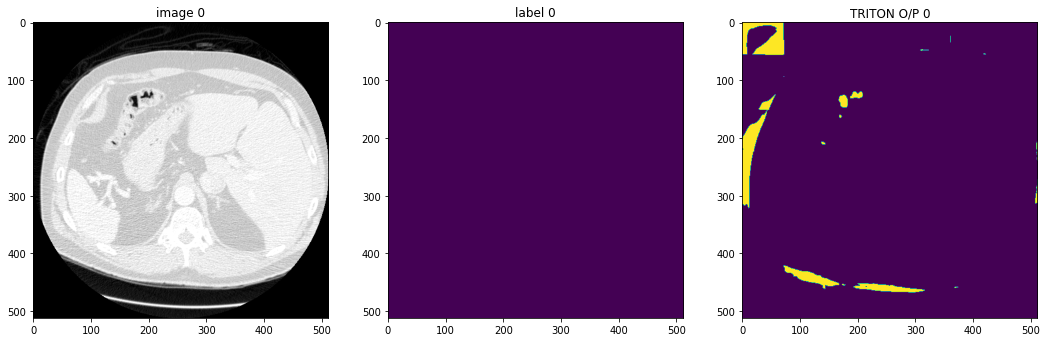

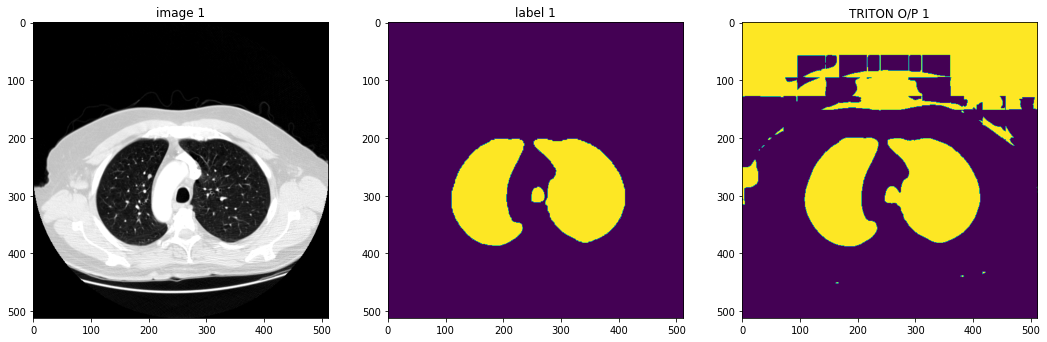

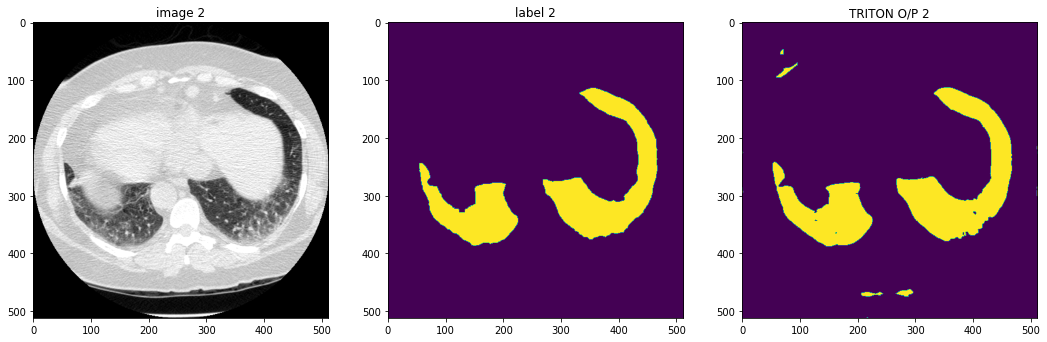

In [8]:
for i, val_data in enumerate(val_loader):
    roi_size = (96, 96, 96)
    sw_batch_size = 8
    val_outputs = sliding_window_inference_triton(val_data['image'], roi_size, sw_batch_size, triton_inferer)
    # plot slice 80
    plt.figure('check', (18, 6))
    plt.subplot(1, 3, 1)
    plt.title(f"image {str(i)}")
    plt.imshow(torch.rot90(val_data['image'][0, 0, :, :, 80],1,[0,1]), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title(f"label {str(i)}")
    plt.imshow(torch.rot90(val_data['label'][0, 0, :, :, 80],1,[0,1]))
    plt.subplot(1, 3, 3)
    plt.title(f"TRITON O/P {str(i)}")
    plt.imshow(torch.rot90(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80],1,[0,1]))
    plt.show()

    if i == 2:
        break

To update the current model with a newer version. 
* Just add the model to the `model_lungseg_graphdef` folder under a new folder call `2/`
* TRITON recongnizes a new update and then loads this new one

In [9]:
list_files('./trtismodelrepo/v2/model_lungseg_graphdef/')

/
    config.pbtxt
2/
    model.graphdef
1/
    model.graphdef


The following message should appear in the logs

`I0804 13:56:11.830064 1 model_repository_manager.cc:888] successfully loaded 'model_lungseg_graphdef' version 2`

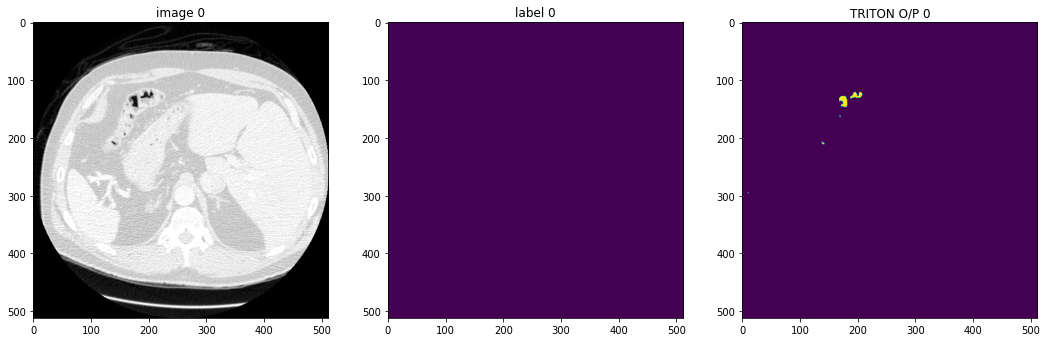

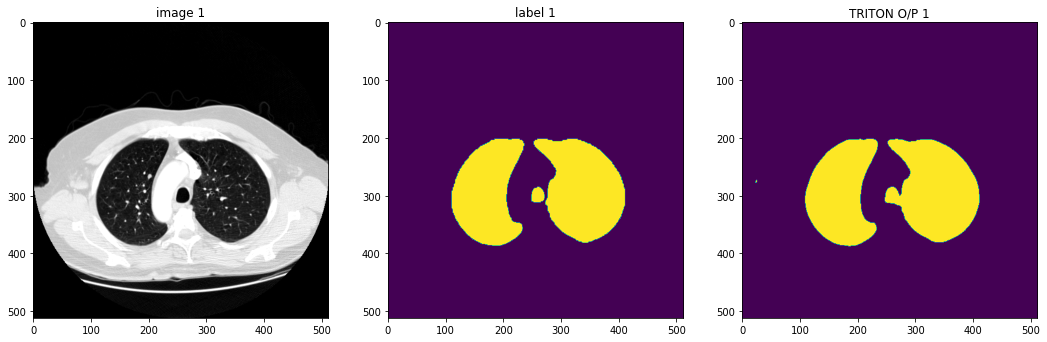

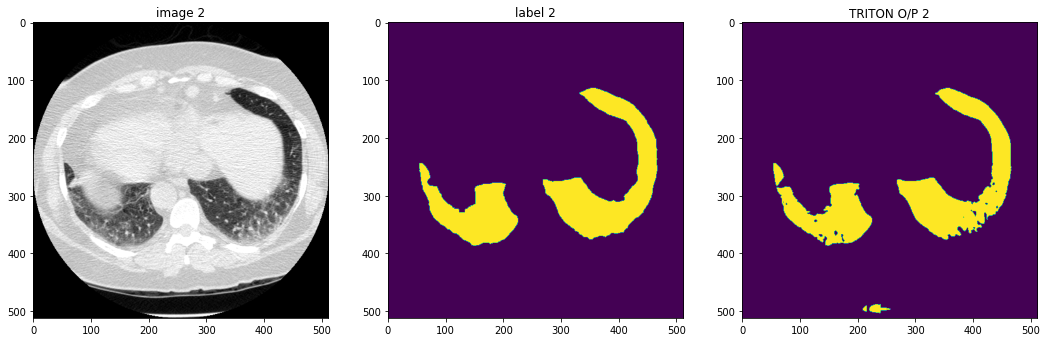

In [10]:
for i, val_data in enumerate(val_loader):
    roi_size = (96, 96, 96)
    sw_batch_size = 8
    val_outputs = sliding_window_inference_triton(val_data['image'], roi_size, sw_batch_size, triton_inferer)
    # plot slice 80
    plt.figure('check', (18, 6))
    plt.subplot(1, 3, 1)
    plt.title(f"image {str(i)}")
    plt.imshow(torch.rot90(val_data['image'][0, 0, :, :, 80],1,[0,1]), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title(f"label {str(i)}")
    plt.imshow(torch.rot90(val_data['label'][0, 0, :, :, 80],1,[0,1]))
    plt.subplot(1, 3, 3)
    plt.title(f"TRITON O/P {str(i)}")
    plt.imshow(torch.rot90(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80],1,[0,1]))
    plt.show()

    if i == 2:
        break

#### Simulate continuous requests from this model
We also run requests with the CXR ONNX model as well as simulate requests for inference every few seconds using the script `sim_inference_req_triton.py`

We monitor Machine/GPU usage on the right as well the TRTIS metrics via the Grafana Dashboard